# Аналитика браузерного проекта

Цель проекта: помочь маркетологам оптимизировать маркетинговые затраты.

У нас в распоряжении есть лог сервера с данными о посещениях сайта проекта с июня 2017 по конец мая 2018 года, выгрузка всех заказов(платных услуг) за этот период, а также статистика рекламных расходов.

В распоряжении:
- лог сервера с данными о посещениях сайта проекта за определенные даты,
- выгрузка всех заказов(платных услуг проекта) за этот период,
- статистика рекламных расходов.

Необходимо понять:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

Анализ будет состоять из следующих шагов:
1. загрузка и предобработка данных
2. анализ визитов (сессий)
3. когортный анализ покупок
4. расчет основных метрик
5. итоги

## Шаг 1. Загрузка и предобработка данных.

In [1]:
import pandas as pd

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358532 entries, 0 to 358531
Data columns (total 5 columns):
Uid          358532 non-null uint64
Device       358532 non-null object
End Ts       358532 non-null object
Source Id    358532 non-null int64
Start Ts     358532 non-null object
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


В данных только одна неточность - поля, которые должны иметь тип datetime являются object, надо поменять. 

In [5]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Данные готовы к дальнейшему анализу

## Шаг 2. Анализ визитов

1. Посчитаем количество визитов каждого пользователя. Посчитаем число пользователей, которые заходили более одного раза и оценим процент таких пользователей и наоборот процент пользователей, которыы зашли только один раз. Также оценим процент пользователей с единичным визитом для каждого источника рекламы. Далее оценим длинну сессей, и посчитаем среднюю длину сессий для каждого рекламного источника, т.е. посмотрим какие источники работают на на целевую аудиторию. 

In [6]:
visits_source_grouped = visits.groupby('Source Id')[['Uid']].count()

In [7]:
visits_source_grouped.sort_values(by = 'Uid', ascending = False)

,Uid
Source Id,
4,101653
3,85448
5,66711
2,47473
1,33943
9,13257
10,10005
7,36
6,6


In [8]:
visits_device_grouped = visits.groupby('Device')[['Uid']].count()
visits_device_grouped.sort_values(by = 'Uid', ascending = False)

,Uid
Device,
desktop,261913
touch,96619


Тройка лидеров рекламы - это источники 4, 3 и 5. Также desktop в 2.7 раз популярнее чем touch. Запомним.

In [9]:
visits_uid_grouped = visits.groupby('Uid')[['Uid']].count()
visits_uid_grouped.columns = ['visit_count']
print('Максимальное число визитов - ', visits_uid_grouped.max())
print('Среднее число визитов - ', visits_uid_grouped.mean())

n_one_visit = visits_uid_grouped.query('visit_count == 1').shape[0]
total_users = visits_uid_grouped.shape[0]
print('Процент единичных визитов - ', n_one_visit/total_users*100)

Максимальное число визитов -  visit_count    893
dtype: int64
Среднее число визитов -  visit_count    1.571344
dtype: float64
Процент единичных визитов -  77.39131959205676


Выглядит не очень - больше 77% пользователей случайные гости на нашем сервисе, т.к. заходят только  один раз. Возможно, однако, что они наши потенциальные клиенты просто заходят редко и их визиты не попали в наш датасет. Рассмотрим длинну сессий, ведь посещения случайных пользователей коротки.

In [10]:
visits['Session duration'] = (visits['End Ts'] - visits['Start Ts']).dt.total_seconds().div(60).astype(int)
visits[visits['Session duration'] == 0].shape[0]/visits.shape[0]*100

9.983488224203139

In [11]:
visits_duration_grouped = visits[visits['Session duration'] == 0].groupby('Source Id')[['Uid']].count()
visits_duration_grouped.columns = ['visit_count']
visits_duration_merged = visits_duration_grouped.merge(visits_source_grouped, left_on='Source Id', right_on='Source Id')
visits_duration_merged['zero_visit_percent'] = visits_duration_merged['visit_count']/visits_duration_merged['Uid']*100
visits_duration_merged.sort_values(by = 'zero_visit_percent', ascending = False)

,visit_count,Uid,zero_visit_percent
Source Id,,,
6,1,6,16.666667
5,7385,66711,11.070138
4,10898,101653,10.720785
3,9025,85448,10.561979
10,1054,10005,10.534733
9,1297,13257,9.783511
2,4158,47473,8.758663
1,1975,33943,5.818578
7,1,36,2.777778


Получили, что рекамный источник 6 - самый неэфективный - и пользователей приходит мало и сессии у них очень короткие, скорее всего пользователи случайные.

2. Теперь посчитаем количество сессий и пользователей за день, неделю, месяц...

In [12]:
visits['day'] = visits['Start Ts'].dt.date
visits['week'] = visits['Start Ts'].dt.week
visits['month'] = visits['Start Ts'].dt.month
visits.head()

,Uid,Device,End Ts,Source Id,Start Ts,Session duration,day,week,month
0,16879256277535980062,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,18,2017-12-20,51,12
1,104060357244891740,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,28,2018-02-19,8,2
2,7459035603376831527,touch,2017-01-07 01:54:00,5,2017-01-07 01:54:00,0,2017-01-07,1,1
3,16174680259334210214,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,24,2018-05-20,20,5
4,9969694820036681168,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,0,2017-12-27,52,12


In [13]:
print('Среднее число сессий в день - ', int(visits.groupby('day')[['Uid']].count().mean()))
print('Среднее число сейссий в неделю - ', int(visits.groupby('week')[['Uid']].count().mean()))
print('Среднее число сессий в месяц - ', int(visits.groupby('month')[['Uid']].count().mean()))

Среднее число сессий в день -  984
Среднее число сейссий в неделю -  6894
Среднее число сессий в месяц -  29877


In [14]:
print('Среднее число пользователей в день - ', int(visits.groupby('day')[['Uid']].nunique().mean()))
print('Среднее число пользователей в неделю - ', int(visits.groupby('week')[['Uid']].nunique().mean()))
print('Среднее число пользователей в месяц - ', int(visits.groupby('month')[['Uid']].nunique().mean()))

Среднее число пользователей в день -  907
Среднее число пользователей в неделю -  5972
Среднее число пользователей в месяц -  24285


## Шаг 3. Когортный анализ заказов

In [15]:
print(orders['Revenue'].max())
print(orders['Revenue'].mean())
orders.query('Revenue > 1000')

2633.28
4.999646930477041


,Buy Ts,Revenue,Uid
23165,2017-12-10 13:04:00,1195.64,5539673724080479777
23244,2017-12-10 20:17:00,2633.28,5539673724080479777
24607,2017-12-17 18:06:00,1109.10,11149926373378902217
36522,2018-02-23 08:54:00,1236.28,11149926373378902217
36682,2018-02-24 09:25:00,1221.37,11149926373378902217
40386,2018-03-18 09:13:00,1073.11,11149926373378902217
47507,2018-05-16 19:53:00,1080.44,11149926373378902217


Есть покупки, которые намного больше среднего значения. Таких покупок немного. Три такие покупки попадают на декабрь 2017 - это может повлиять на дальнейшие результаты -запомним.

In [16]:
# Для начала сформируем когорты по месяцам покупки
first_order_date_by_customers = orders.groupby('Uid')['Buy Ts'].min().reset_index()
first_order_date_by_customers.columns = ['Uid', 'first_order_date']
orders = orders.merge(first_order_date_by_customers,on='Uid')
print(orders.head(10))

               Buy Ts  Revenue                   Uid    first_order_date
0 2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:10:00
1 2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:25:00
2 2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:27:00
3 2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:29:00
4 2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:58:00
5 2017-06-01 08:43:00     0.18  10402394430196413321 2017-06-01 08:43:00
6 2017-06-01 08:54:00     1.83  12464626743129688638 2017-06-01 08:54:00
7 2017-06-05 14:30:00     7.33  12464626743129688638 2017-06-01 08:54:00
8 2017-06-01 09:22:00     1.22   3644482766749211722 2017-06-01 09:22:00
9 2017-06-02 12:44:00     0.85   3644482766749211722 2017-06-01 09:22:00


In [17]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [18]:
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [19]:
# Построим сводную таблицу
orders.pivot_table(index='first_order_month',
    columns='order_month',
    values='Uid',
    aggfunc='nunique')

order_month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
first_order_month,,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0,NaN
2017-07-01,NaN,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,NaN,NaN,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN
2017-09-01,NaN,NaN,NaN,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN
2017-10-01,NaN,NaN,NaN,NaN,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4383.0,146.0,103.0,97.0,50.0,63.0,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3373.0,114.0,83.0,43.0,45.0,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3651.0,118.0,58.0,39.0,NaN


После первого месяца количество покупателей в когорте снижается.

In [20]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'Revenue':'sum','Uid':'nunique'})
print(orders_grouped_by_cohorts.head())

                               Revenue   Uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88


In [21]:
# Найдём средний чек покупателя
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['Revenue'] / orders_grouped_by_cohorts['Uid']

In [22]:
# Построим сводную таблицу изменения среднего чека в когортах по месяцу совершения покупки и оценим, 
# как изменяется средний чек с течением времени
orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean')

order_month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


In [23]:
# Найдём lifetime когорты. для оценки того,
# как изменяется средний чек в зависимости от времени, прошедшего с момента первой покупки
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'].head()

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [24]:
import numpy as np

orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
print(orders_grouped_by_cohorts['cohort_lifetime'].head())

0    0.000000
1    0.985647
2    2.004148
3    3.022649
4    4.008296
Name: cohort_lifetime, dtype: float64


In [25]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head())
print(orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].tail())

  first_order_month order_month  cohort_lifetime
0        2017-06-01  2017-06-01                0
1        2017-06-01  2017-07-01                1
2        2017-06-01  2017-08-01                2
3        2017-06-01  2017-09-01                3
4        2017-06-01  2017-10-01                4
   first_order_month order_month  cohort_lifetime
74        2018-03-01  2018-05-01                2
75        2018-04-01  2018-04-01                0
76        2018-04-01  2018-05-01                1
77        2018-05-01  2018-05-01                0
78        2018-06-01  2018-06-01                0


In [26]:
# Получили целое число месяцев, обозначающее порядковый месяц совершения покупки относительно месяца первой покупки.
# Когда все расчёты выполнены, оставим в обозначении когорты только год и месяц. 
orders_grouped_by_cohorts['first_order_month'].dt.strftime('%d.%m.%Y')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [27]:
# Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
print(revenue_per_user_pivot)

cohort_lifetime          0          1          2           3          4   \
first_order_month                                                          
2017-06            4.724414  16.095410  17.706800   35.764815  23.506591   
2017-07            6.010218  12.396346  21.035965   10.786094   6.938163   
2017-08            5.276518  11.148793  11.851321   12.182955  16.921250   
2017-09            5.644529  22.188385  13.445200  138.669189  19.881538   
2017-10            5.003733  11.287427   6.753252    7.413152   7.072796   
2017-11            5.154683   7.339054   6.786583   12.510660   7.457284   
2017-12            4.738191   7.816575  39.366019   48.135052  27.431400   
2018-01            4.135636   8.721228  12.365542   11.199767   4.699556   
2018-02            4.156987   8.610000   4.942414    6.941026        NaN   
2018-03            4.838803  11.811667  19.221897         NaN        NaN   
2018-04            4.657597  17.535072        NaN         NaN        NaN   
2018-05     

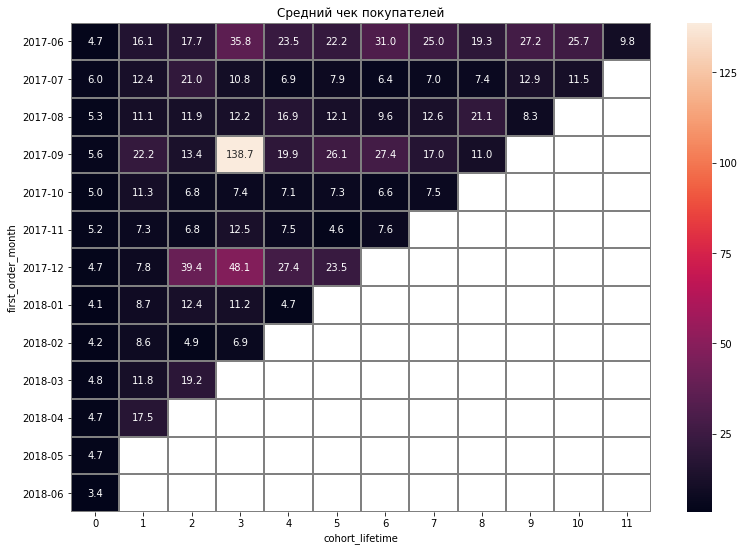

In [54]:
# Визуализируем с помощью тепловой карты
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')

## Шаг 4. Объединение таблиц. Расчет основных показателей

1. Объединим таблицы visits и orders. В сводной нас будет Uid, SourceId + информация по заказам. мы посмотрим, когда клиент начинает покупать и из каких рекламных источников клиенты приносят больше всего денег.

Объединим таблицы visits и costs. Из сводной таблицы получим затраты на рекламы на кождого пользователя и на каждый визит по месяцам.

In [29]:
visits_orders = visits.groupby('Uid')[['Start Ts']].min().reset_index()
visits_orders = pd.merge(visits_orders, visits, how='left', on=['Uid', 'Start Ts'])
visits_orders = visits_orders.drop(columns=['day', 'week', 'month', 'Device', 'End Ts', 'Session duration'])
visits_orders = pd.merge(orders, visits_orders, how='left', on='Uid')

In [30]:
visits_orders['visit_to_order'] = (pd.to_datetime(visits_orders['first_order_date']).dt.date - visits_orders['Start Ts'].dt.date).astype('int64')/(24*60*60*1000000000)
visits_orders['visit_to_order'] = visits_orders['visit_to_order'].astype('int')
visits_orders.head()

,Buy Ts,Revenue,Uid,first_order_date,first_order_month,order_month,Start Ts,Source Id,visit_to_order
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-01-06 00:09:00,1,146
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-01-06 00:14:00,2,146
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-01-06 00:25:00,2,146
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-01-06 00:14:00,2,146
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-01-06 07:31:00,3,146


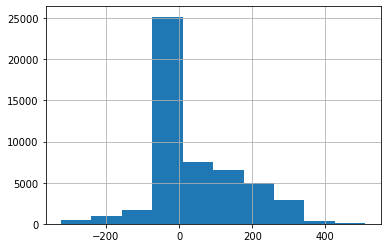

In [31]:
visits_orders['visit_to_order'].hist()

Видно, что подавляющее большинство пользователей делают заказ в первые дни после первого визита. Также есть данные, когда информация о заказе опережает информацию о визите, скорее всего этот хвост надо будет отбросить.

In [32]:
print('Процент пользователей, которые сделали первый заказ при первом визите - ', visits_orders.query('visit_to_order == 0').shape[0]/visits_orders.shape[0]*100)

Процент пользователей, которые сделали первый заказ при первом визите -  37.74868590697213


Посмотрим из каких рекламных источников приходят пользователи и сразу делают заказ.

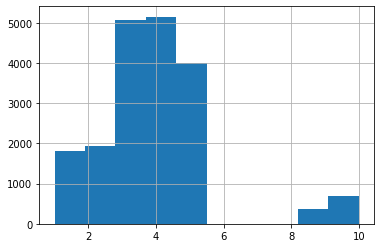

In [33]:
visits_orders_first = visits_orders.query('visit_to_order == 0')
visits_orders_first['Source Id'].hist()

Источники 3 и 4 самые таргетированные.

In [34]:
# Посмотрим доход от пользователей для каждого рекламного источника
revenue_per_source = visits_orders.groupby('Source Id').agg({'Revenue':'sum'})
revenue_per_source.sort_values(by = 'Revenue', ascending = False)

,Revenue
Source Id,
2,64055.41
4,53230.65
3,49872.84
5,40512.36
1,33316.97
9,6630.29
10,4437.46
7,1.22


Здесь источники 3 и 4 тоже в лидерах, но максимальную прибыль принес источник 2.

2. Расчитаем ROMI для различных периодов времени

In [35]:
costs['day'] = costs['dt'].dt.date
costs['week'] = costs['dt'].dt.week
costs['month'] = costs['dt'].dt.month
visits_costs = visits_orders
visits_costs  = visits_costs.drop(columns=['first_order_date', 'first_order_month', 'order_month', 'Start Ts', 'visit_to_order'])
visits_costs['day'] = visits_costs['Buy Ts'].dt.date
visits_costs['week'] = visits_costs['Buy Ts'].dt.week
visits_costs['month'] = visits_costs['Buy Ts'].dt.month

In [36]:
costs_by_day = costs.groupby(['day', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_by_week = costs.groupby(['week', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_by_month = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
revenue_by_day = visits_costs.groupby(['day', 'Source Id']).agg({'Revenue':'sum'}).reset_index()
revenue_by_week = visits_costs.groupby(['week', 'Source Id']).agg({'Revenue':'sum'}).reset_index()
revenue_by_month = visits_costs.groupby(['month', 'Source Id']).agg({'Revenue':'sum'}).reset_index()
revenue_by_day = revenue_by_day.rename(columns={"Source Id": "source_id"})
revenue_by_week = revenue_by_week.rename(columns={"Source Id": "source_id"})
revenue_by_month = revenue_by_month.rename(columns={"Source Id": "source_id"})
print()

In [37]:
romi_month = revenue_by_month.merge(costs_by_month, on=['month', 'source_id'])
romi_month['romi'] = (romi_month['Revenue'] - romi_month['costs'])/romi_month['costs']

romi_week = revenue_by_week.merge(costs_by_week, on=['week', 'source_id'])
romi_week['romi'] = (romi_week['Revenue'] - romi_week['costs'])/romi_week['costs']

romi_day = revenue_by_day.merge(costs_by_day, on=['day', 'source_id'])
romi_day['romi'] = (romi_day['Revenue'] - romi_day['costs'])/romi_day['costs']

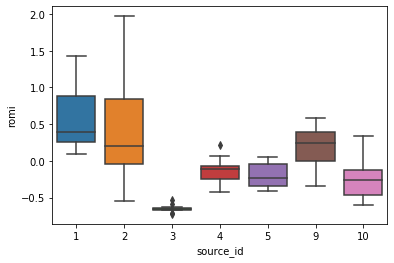

In [38]:
import matplotlib.pyplot as plt
import seaborn as sn

# помесечные ROMI
ax = sns.boxplot(x="source_id", y="romi", data=romi_month)

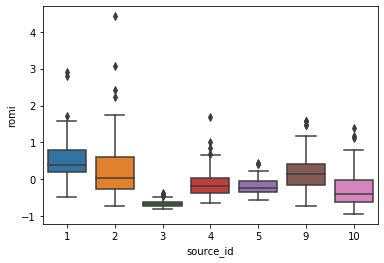

In [39]:
# недельные ROMI
ax = sns.boxplot(x="source_id", y="romi", data=romi_week)

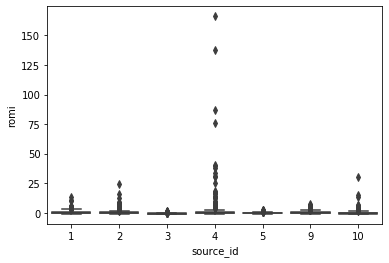

In [40]:
# дневные ROMI
ax = sns.boxplot(x="source_id", y="romi", data=romi_day)

Здесь видно, что источники 1, 2 и 9 наиболее окупаемые, для других рекламных источников средняя окупаемость ниже 0 - т.е. они убыточны и, возможно, стоит от них оказаться. 
Дневные графики показывают, что в большинство дней ROMI около 0 т.е. затраты почти рабны прибыли, однако есть большие всплеки, особенно для источникоа 4.

3. Рассчитаем LTV

In [41]:
first_orders = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']
print(first_orders.head())

                Uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


In [42]:
# посчитаем количество покупателей каждый месяц
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head())

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


In [43]:
cohorts = orders.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
print(cohorts.head())

  first_order_month order_month  Revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58


In [44]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
print(report.head())

  first_order_month  n_buyers order_month  Revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58


In [45]:
margin_rate = 1
    
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
print(report.head())

  first_order_month  n_buyers order_month  Revenue       gp  age
0        2017-06-01      2023  2017-06-01  9557.49  9557.49    0
1        2017-06-01      2023  2017-07-01   981.82   981.82    1
2        2017-06-01      2023  2017-08-01   885.34   885.34    2
3        2017-06-01      2023  2017-09-01  1931.30  1931.30    3
4        2017-06-01      2023  2017-10-01  2068.58  2068.58    4


In [46]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round()
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,5.0,0,0,1,1,1,1,1,1,1,1,0
2017-07-01,6.0,0,1,0,0,0,0,0,0,0,0,
2017-08-01,5.0,0,0,0,0,0,0,0,0,0,,
2017-09-01,6.0,1,1,4,0,1,1,0,0,,,
2017-10-01,5.0,1,0,0,0,0,0,0,,,,
2017-11-01,5.0,0,0,0,0,0,0,,,,,
2017-12-01,5.0,0,1,1,0,0,,,,,,
2018-01-01,4.0,0,0,0,0,,,,,,,
2018-02-01,4.0,0,0,0,,,,,,,,


In [47]:
ltv2017_06_01 = output.loc['2017-06-01'].sum() 
print(ltv2017_06_01)

13.0


In [48]:
# отфильруем нужную когорту
cohort2017_06_01 = report[report['first_order_month'] == '2017-06-01']

# посчитаем расходы за этот месяц
costs2017_06_01= costs[costs['month'] == '2017-06-01']['costs'].sum()

n_buyers2017_06_01= cohort2017_06_01['n_buyers'][0]
cac2017_06_01= costs2017_06_01/ n_buyers2017_06_01
ltv2017_06_01  = output.loc['2017-06-01'].sum()

print('CAC =', cac2017_06_01)
print('LTV =', ltv2017_06_01)

CAC = 0.0
LTV = 13.0


/opt/conda/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [49]:
# считаем расходы за месяц
monthly_costs = costs.groupby('month').sum()
monthly_costs.head()

,source_id,costs,week
month,,,
1,1054,33518.52,595
2,952,32723.03,1358
3,1025,30415.27,2337
4,986,22289.38,3164
5,1054,22224.27,4312


In [50]:
report['first_order_month'] = report['first_order_month'].dt.month
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv,source_id,costs,week,cac
0,6,2023,2017-06-01,9557.49,9557.49,0,4.724414,1020,18015.0,5054,8.905091
1,6,2023,2017-07-01,981.82,981.82,1,0.485329,1020,18015.0,5054,8.905091
2,6,2023,2017-08-01,885.34,885.34,2,0.437637,1020,18015.0,5054,8.905091
3,6,2023,2017-09-01,1931.30,1931.30,3,0.954671,1020,18015.0,5054,8.905091
4,6,2023,2017-10-01,2068.58,2068.58,4,1.022531,1020,18015.0,5054,8.905091


In [51]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
1,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.56,0.60,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.48,0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.27,0.32,0.37,0.48,0.59,0.67,0.78,0.85,0.91,0.98,1.04,1.07
7,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
8,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
9,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN


In [52]:
output.cumsum(axis=1).mean(axis=0)

age
0     0.518718
1     0.557879
2     0.604552
3     0.690277
4     0.749800
5     0.821995
6     0.852624
7     0.916917
8     0.987579
9     0.876098
10    0.962073
11    1.068812
dtype: float64

В среднем когорты окупаются к концу 11 месяцев.

## Итоги.

Анализ сессий показал, что больше 77% пользователей случайные гости на нашем сервисе, т.к. заходят только один раз, а значит реклама не слишком таргетированная. Более того почти 10% сессий длятся меньше минуты, а значит пользователь не только не заинтересован в использовании сервиса, но и в принципе не успевает с нам ознакомится, а значит он даже не потенциальный клиент.

Однако, были выделены рекламные источники, приведшие больше всего пользователей. Тройка лидеров рекламы - это источники 4, 3 и 5. Также мы получили, что рекамный источник 6 - самый неэфективный - и пользователей приходит мало и сессии у них очень короткие, скорее всего пользователи случайные.

Когортный анализ показал, что после первого месяца использования количество покупателей в когорте резко снижается. Далее идут лишь небольшие вариации в ту или иную стороно, но в целом продажи не растут.

Достаточно большой процент пользователей, которые сделали первый заказ при первом визите -  37.75%. Большинство из этих пользователей пришли из рекламных источников 3 и 4, т.е. они самые таргетированные.

Анализ метрик показал, что в среднем когорты окупаются к концу 11 месяцев.